# Pixel-wise to image-wise classification

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Choice of MVTec class

In [2]:
mvtec_class = 'carpet'

## Set up

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# %cd "C:\Users\Public\Documents\DIMA\fcdd\python\analyse"

In [5]:
%cd /content/drive/MyDrive/fcdd/python/analyse

/content/drive/MyDrive/fcdd/python/analyse


In [6]:
from pathlib import Path

FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data" # est-ce le bon dossier ?
DATA_DIR.mkdir(exist_ok=True)

SNAPSHOTS_DIR = Path("../../data")
assert SNAPSHOTS_DIR.exists()

MVTECAD_DIR = Path("../../data/datasets/mvtec") # est-ce le bon dossier ?
assert MVTECAD_DIR.exists()

RECORDS_FPATH = DATA_DIR / "snapshot.pt"

HEATMAPS_DIR = Path(".") / "data" / "generated_heatmaps" / f"{mvtec_class}_train_test"

In [7]:
%matplotlib inline

In [8]:
import numpy as np

## Load datasets

### Load images

In [9]:
IMAGES_GLOB = "*.png"

imgs = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)
classdir = MVTECAD_DIR / mvtec_class


# print(f"{classdir.name=}")

traindir = classdir / "train"
testdir = classdir / "test"

# print(f"{testdir.name=}")

for typedir in testdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    # print(f"{typedir.name=}")
    
    img_paths = list(typedir.glob(IMAGES_GLOB))
    
    if len(img_paths) == 0:
        print("empty dir")
        continue  
    
    # print(f"{len(img_paths)=}")      
    
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "test",
            "imgidx": int(imgpath.stem),
        })

img_paths = list((traindir / "good").glob(IMAGES_GLOB))

if len(img_paths) == 0:
    print("empty dir")

else:
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": "good",
            "set": "train",
            "imgidx": int(imgpath.stem),
        })    

print(30 * "-")

# print(f"{len(imgs)=}")

------------------------------


In [10]:
import pandas as pd
imgs = pd.DataFrame.from_records(data=imgs).set_index(["class", "set", "type", "imgidx"])
imgs

imgpath
class  set   type imgidx                                                   
carpet test  cut  14      /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  5       /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  7       /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  15      /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  16      /content/drive/MyDrive/fcdd/data/datasets/mvte...
...                                                                     ...
       train good 275     /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  279     /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  277     /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  276     /content/drive/MyDrive/fcdd/data/datasets/mvte...
                  278     /content/drive/MyDrive/fcdd/data/datasets/mvte...

[397 rows x 1 columns]

In [11]:
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

images_loaded = []

for path in list(imgs["imgpath"].to_numpy()):
    img = image.imread(path)
    img_resized = resize(img, (224, 224),
                       anti_aliasing=True)
    images_loaded.append(img_resized)

images_loaded = np.array(images_loaded)
images_loaded.shape

(397, 224, 224, 3)

In [12]:
images_loaded = np.reshape(images_loaded, (397, 3, 224, 224))
images_loaded.shape

(397, 3, 224, 224)

### Load heatmaps

In [13]:
IMAGES_GLOB = "*.png"

heatmaps_loaded = []

heatmaps_dir = HEATMAPS_DIR

for hm_path in heatmaps_dir.glob("*"):
    hm = image.imread(hm_path)
    hm_resized = resize(hm, (224, 224),
                       anti_aliasing=True)
    heatmaps_loaded.append(hm_resized)

heatmaps_loaded = np.array(heatmaps_loaded)
heatmaps_loaded.shape
    

(397, 224, 224, 4)

In [14]:
# We reduce to only one dimension per pixel:

heatmaps_reduced_loaded = []

for hm in heatmaps_loaded:
    # hm.shape
    heatmaps_reduced_loaded.append(np.mean(hm, 2))

heatmaps_reduced_loaded = np.array(heatmaps_reduced_loaded)
heatmaps_reduced_loaded.shape

(397, 224, 224)

In [15]:
# im_test1 = heatmaps_loaded[0]
# im_test2 = heatmaps_reduced_loaded[0]
# import matplotlib.pyplot as plt
# plt.imshow(im_test1)
# plt.imshow(im_test2)

### Pair images and heatmaps

In [16]:
import torch

In [17]:
heatmaps_reduced_loaded = torch.from_numpy(heatmaps_reduced_loaded)
heatmaps_reduced_loaded = torch.squeeze(heatmaps_reduced_loaded)
heatmaps_reduced_loaded = torch.unsqueeze(heatmaps_reduced_loaded, 1)
heatmaps_reduced_loaded.shape

torch.Size([397, 1, 224, 224])

In [18]:
images_loaded = torch.from_numpy(images_loaded)
images_loaded.shape

torch.Size([397, 3, 224, 224])

In [19]:
train_images = torch.cat((images_loaded, heatmaps_reduced_loaded), 1)
train_images.shape

torch.Size([397, 4, 224, 224])

## Get labels

### Load masks of test set

In [20]:
MASKS_GLOB = "*.png"

masks_test = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)

classdir = MVTECAD_DIR / mvtec_class

# print(f"{classdir.name=}")

groundtruthdir = classdir / "ground_truth"

# print(f"{groundtruthdir.name=}")

for typedir in groundtruthdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    # print(f"{typedir.name=}")
    
    masks_paths = list(typedir.glob(MASKS_GLOB))
    
    if len(masks_paths) == 0:
        print("empty dir")
        continue
    
    # print(f"{len(masks_paths)=}")
    
    for maskpath in masks_paths:
        masks_test.append({
            "mask_path": maskpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "ground_truth",
            "mask_idx": int(maskpath.stem[:3]),
        })
        

print(30 * "-")

# print(f"{len(masks_test)=}")

------------------------------


In [21]:
import pandas as pd
df_masks_test = pd.DataFrame.from_records(data=masks_test).set_index(["class", "type", "set", "mask_idx"])
df_masks_test

mask_path
class  type   set          mask_idx                                                   
carpet cut    ground_truth 12        /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           1         /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           5         /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           9         /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           11        /content/drive/MyDrive/fcdd/data/datasets/mvte...
...                                                                                ...
       thread ground_truth 17        /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           5         /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           8         /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           10        /content/drive/MyDrive/fcdd/data/datasets/mvte...
                           16        /content/drive/MyDrive/fcdd/data/datasets/mvte...

[89 rows x 1 columns]

#### Complete the masks of the test set

In [22]:
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

masks_test_anormal = []

for path in list(df_masks_test["mask_path"].to_numpy()):
    img = image.imread(path)
    img_resized = resize(img, (224, 224),
                       anti_aliasing=True)
    masks_test_anormal.append(img_resized)

In [23]:
masks_test_normal = []
for i in range(28):
    mask = np.zeros((224,224))
    masks_test_normal.append(mask)

In [24]:
all_masks_test = np.array(masks_test_anormal[:36]+masks_test_normal+masks_test_anormal[36:])
all_masks_test.shape

(117, 224, 224)

### Create the masks of the train set

In [25]:
masks_train = []

img_nb = 280

for i in range(img_nb):
    mask = np.zeros((224,224))
    masks_train.append(mask)

masks_train = np.array(masks_train)
masks_train.shape

(280, 224, 224)

### Combine the two sets of masks

In [26]:
masks = np.concatenate((all_masks_test, masks_train))

### From the masks get the label

In [27]:
labels = np.any(masks, axis=(1,2)).astype(float)
labels.shape

(397,)

In [28]:
anomaly_rate = sum(labels)/len(labels)

In [29]:
labels = torch.from_numpy(labels)
labels.shape

torch.Size([397])

## Learning of classification

### Create sets

In [30]:
labels = labels.type(torch.LongTensor)

In [31]:
import sklearn.model_selection as sk

X_train, X_test, y_train, y_test = sk.train_test_split(train_images, labels, test_size=0.33, random_state = 42)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

torch.Size([265, 4, 224, 224])

torch.Size([265])

torch.Size([132, 4, 224, 224])

torch.Size([132])

### Batch sets

In [32]:
batch_size = 53

In [33]:
# Xtrainloader=torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=False, num_workers=8)
# ytrainloader=torch.utils.data.DataLoader(y_train, batch_size=batch_size, shuffle=False, num_workers=8)
train_set = list(zip(X_train, y_train))
train_batch = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)

### Create a CNN

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
in_size = 4
hid1_size = 16
hid2_size = 32
hid3_size = 64
hid4_size = 64
out_size = 2
k_conv_size = 4

In [36]:
torch.cuda.empty_cache()

In [37]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.layer1a = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, kernel_size=1, padding=1)
        )

        self.layer1b = nn.Sequential(
            nn.Conv2d(hid1_size, hid1_size, k_conv_size, padding=2),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            # nn.Conv2d(hid1_size, hid1_size, k_conv_size, padding=2),
            # nn.BatchNorm2d(hid1_size),
            # nn.ReLU(),
            # nn.Conv2d(hid1_size, hid1_size, k_conv_size, padding=1),
            # nn.BatchNorm2d(hid1_size),
            # nn.ReLU(),
            nn.Conv2d(hid1_size, hid1_size, k_conv_size, padding=1)
        )

        self.layer1c = nn.Sequential(
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid1_size, hid1_size, kernel_size=2, stride=2, padding=0)
        )

        self.layer2a = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, kernel_size=1, padding=1)
        )

        self.layer2b = nn.Sequential(
            nn.Conv2d(hid2_size, hid2_size, k_conv_size, padding=2),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            # nn.Conv2d(hid2_size, hid2_size, k_conv_size, padding=2),
            # nn.BatchNorm2d(hid2_size),
            # nn.ReLU(),
            # nn.Conv2d(hid2_size, hid2_size, k_conv_size, padding=1),
            # nn.BatchNorm2d(hid2_size),
            # nn.ReLU(),
            nn.Conv2d(hid2_size, hid2_size, k_conv_size, padding=1)
        )

        self.layer2c = nn.Sequential(
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid2_size, hid2_size, kernel_size=2, stride=2, padding=0)
        )

        self.layer3a = nn.Sequential(
            nn.Conv2d(hid2_size, hid3_size, kernel_size=1, padding=1)
        )

        self.layer3b = nn.Sequential(
            nn.Conv2d(hid3_size, hid3_size, k_conv_size, padding=2),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            # nn.Conv2d(hid3_size, hid3_size, k_conv_size, padding=2),
            # nn.BatchNorm2d(hid3_size),
            # nn.ReLU(),
            # nn.Conv2d(hid3_size, hid3_size, k_conv_size, padding=1),
            # nn.BatchNorm2d(hid3_size),
            # nn.ReLU(),
            nn.Conv2d(hid3_size, hid3_size, k_conv_size, padding=1)
        )

        self.layer3c = nn.Sequential(
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid3_size, hid3_size, kernel_size=2, stride=2, padding=0)
        )

        self.layer4a = nn.Sequential(
            nn.Conv2d(hid3_size, hid4_size, kernel_size=1, padding=1)
        )

        self.layer4b = nn.Sequential(
            nn.Conv2d(hid4_size, hid4_size, k_conv_size, padding=2),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            # nn.Conv2d(hid4_size, hid4_size, k_conv_size, padding=2),
            # nn.BatchNorm2d(hid4_size),
            # nn.ReLU(),
            # nn.Conv2d(hid4_size, hid4_size, k_conv_size, padding=1),
            # nn.BatchNorm2d(hid4_size),
            # nn.ReLU(),
            nn.Conv2d(hid4_size, hid4_size, k_conv_size, padding=1)
        )

        self.layer4c = nn.Sequential(
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid4_size, hid4_size, kernel_size=2, stride=2, padding=0)
        )

        self.fc = nn.Linear(14400, out_size)


    def forward(self, x):

        # Layer 1
        out = self.layer1a(x)
        # print(out.shape)
        residual1 = out

        out = self.layer1b(out)
        # print(out.shape)
        out = residual1 + out

        out = self.layer1c(out)
        # print(out.shape)

        # Layer 2
        out = self.layer2a(out)
        # print(out.shape)
        residual2 = out

        out = self.layer2b(out)
        # print(out.shape)
        out = residual2 + out

        out = self.layer2c(out)
        # print(out.shape)

        # Layer 3
        out = self.layer3a(out)
        # print(out.shape)
        residual3 = out

        out = self.layer3b(out)
        # print(out.shape)
        out = residual3 + out

        out = self.layer3c(out)
        # print(out.shape)

        # Layer 4
        out = self.layer4a(out)
        # print(out.shape)
        residual4 = out

        out = self.layer4b(out)
        # print(out.shape)
        out = residual4 + out

        out = self.layer4c(out)
        # print(out.shape)

        out = torch.reshape(out, (out.size(0), 14400))
        # print(out.shape)

        out = self.fc(out)
        print(out.shape)

        return out

In [38]:
model = ConvNet()

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
model.to(device)

ConvNet(
  (layer1a): Sequential(
    (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (layer1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (layer1c): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (layer2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (layer2c): Sequential

In [41]:
# X_train = X_train.to(device)
# y_train = y_train.to(device)

### Train the CNN

In [42]:
learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [43]:
from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.95)

In [44]:
num_epochs = 100
loss_values = list()

In [45]:
for epoch in range(num_epochs):
    # print(type(x),type(y))
    print(epoch)

    for i, data in enumerate(train_batch) :
        x, y = data
        X_train = x.to(device)
        y_train = y.to(device)
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(loss.item())
        loss_values.append(loss.item())

0
torch.Size([53, 2])
0.7659980654716492
torch.Size([53, 2])
2.192018985748291
torch.Size([53, 2])
0.2781025469303131
torch.Size([53, 2])
0.45222994685173035
torch.Size([53, 2])
0.48044824600219727
1
torch.Size([53, 2])
0.34519991278648376
torch.Size([53, 2])
0.33790847659111023
torch.Size([53, 2])
0.36898526549339294
torch.Size([53, 2])
0.23193565011024475
torch.Size([53, 2])
0.2949174642562866
2
torch.Size([53, 2])
0.23741920292377472
torch.Size([53, 2])
0.11378005146980286
torch.Size([53, 2])
0.1458483785390854
torch.Size([53, 2])
0.13967826962471008
torch.Size([53, 2])
0.1664735972881317
3
torch.Size([53, 2])
0.07787369936704636
torch.Size([53, 2])
0.06201549619436264
torch.Size([53, 2])
0.054539307951927185
torch.Size([53, 2])
0.05682329460978508
torch.Size([53, 2])
0.06271543353796005
4
torch.Size([53, 2])
0.037173375487327576
torch.Size([53, 2])
0.03726600483059883
torch.Size([53, 2])
0.02885608561336994
torch.Size([53, 2])
0.026248905807733536
torch.Size([53, 2])
0.025482853874

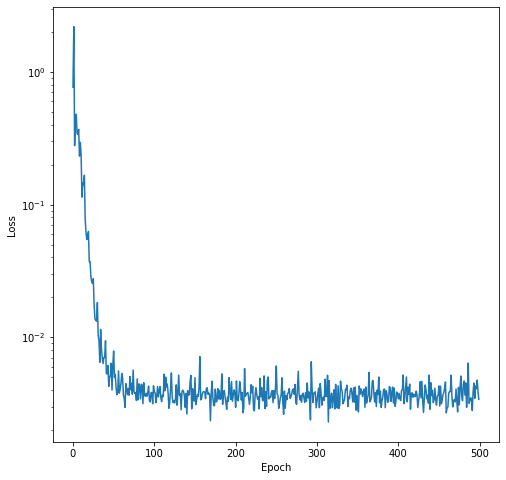

In [46]:
import matplotlib.pyplot as plt

x = range(len(loss_values))
plt.figure(figsize= (8, 8));
plt.plot(x, loss_values);
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.yscale('log');

### Evaluate the results

In [47]:
X_test = X_test.to(device)
y_test = y_test.to(device)

In [48]:
model.eval()

ConvNet(
  (layer1a): Sequential(
    (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (layer1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (layer1c): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (layer2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (layer2c): Sequential

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [50]:
with torch.no_grad():
    correct = 0
    total = 0

    CNN_outputs = model(X_test)
    CNN_outputs_probabilities = torch.softmax(CNN_outputs, 1)
    _, predictions = torch.max(CNN_outputs.data, 1)

    y_test_np = y_test.cpu().numpy()
    predictions = predictions.cpu()

    print("Accuracy: ", accuracy_score(y_test_np, predictions))
    print("Precision: ", precision_score(y_test_np, predictions, average='weighted'))
    print("Recall: ", recall_score(y_test_np, predictions, average='weighted'))
    print("F1 score: ", f1_score(y_test_np, predictions, average='weighted'))

torch.Size([132, 2])
Accuracy:  0.8409090909090909
Precision:  0.8506883506883507
Recall:  0.8409090909090909
F1 score:  0.8245856665038145


In [51]:
# CNN_outputs_probabilities
predictions_proba = CNN_outputs_probabilities.cpu().numpy()
predictions_proba = predictions_proba[:,1]

In [52]:
# print(y_test)
# print(predictions)

### Plot the results: ROC AUC

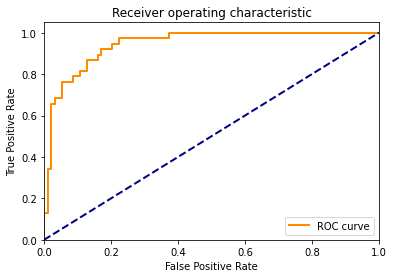

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_np, predictions_proba)

plt.figure();
plt.plot(fpr, tpr,color="darkorange", lw=2, label="ROC curve");
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--");
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("Receiver operating characteristic");
plt.legend(loc="lower right");

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_np, predictions_proba)

0.944568868980963

In [55]:
anomaly_rate

0.22418136020151133